### Preparando arquivos

In [4]:
import os
from shutil import copyfile
import zipfile

def unzip_data(zip_file, data_dir):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(data_dir)


def create_data_dir(data_dir):
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    train_dir = os.path.join(data_dir, 'train')
    test_dir = os.path.join(data_dir, 'test')
    val_dir = os.path.join(data_dir, 'val')
    if not os.path.exists(train_dir):
        os.mkdir(train_dir)
    if not os.path.exists(train_dir):
        os.mkdir(train_dir)
    if not os.path.exists(test_dir):
        os.mkdir(test_dir)
    if not os.path.exists(val_dir):
        os.mkdir(val_dir)
    return train_dir, test_dir, val_dir


def split_data(origin_dir, data_dir, train_dir, test_dir, val_dir, train_percentage, val_percentage):
    unzip_data(os.path.join('.', 'animals.zip'), os.path.join('.'))
    for c in os.listdir(origin_dir):
        class_size = len(os.listdir(os.path.join(origin_dir, c)))
        train_size = int(class_size * train_percentage)
        val_size = int(class_size * val_percentage)
        class_dir = os.path.join(origin_dir, c)
        if not os.path.exists(os.path.join(train_dir, c)):
            os.mkdir(os.path.join(train_dir, c))
        if not os.path.exists(os.path.join(val_dir, c)):
            os.mkdir(os.path.join(val_dir, c))
        for i, img in enumerate(os.listdir(class_dir)):
            if i < train_size:
                copyfile(os.path.join(class_dir, img), os.path.join(train_dir, c, img))
            elif i < train_size + val_size:
                copyfile(os.path.join(class_dir, img), os.path.join(val_dir, c, img))
            else:
                copyfile(os.path.join(class_dir, img), os.path.join(test_dir, img))


def get_size_class(data_dir):
    for c in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, c)
        print(c, len(os.listdir(class_dir)))



ORIGIN_DIR=os.path.join('.', 'animals')
DATA_DIR=os.path.join('.', 'data')
TRAIN_DIR, TEST_DIR, VAL_DIR = create_data_dir(DATA_DIR)

split_data(ORIGIN_DIR, DATA_DIR, TRAIN_DIR, TEST_DIR, VAL_DIR, 0.7, 0.2)

print("Size of each class in origin data")
get_size_class(ORIGIN_DIR)
print("Size of each class in train data")
get_size_class(TRAIN_DIR)
print("Size of each class in val data")
get_size_class(VAL_DIR)
print("Size of test data")
print(len(os.listdir(TEST_DIR)))



Size of each class in origin data
cats 1000
dogs 1000
panda 1000
Size of each class in train data
cats 700
dogs 700
panda 700
Size of each class in val data
cats 200
dogs 200
panda 200
Size of test data
300


### Pré-processamento das imagens

In [5]:
#Definição das constantes
WIDTH = 160
HEIGHT = 160
COLOR_CHANNELS = 3
CHANNEL_SIZE = 255
IMAGE_SIZE = (WIDTH, HEIGHT)
IMAGE_SHAPE = IMAGE_SIZE + (COLOR_CHANNELS,)

BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

#Rescale images

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Loading Data com Normalização
train_datagen = ImageDataGenerator(rescale=1./CHANNEL_SIZE)
val_datagen = ImageDataGenerator(rescale=1./CHANNEL_SIZE)
test_datagen = ImageDataGenerator(rescale=1./CHANNEL_SIZE)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

Found 2100 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 0 images belonging to 0 classes.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 64)       0

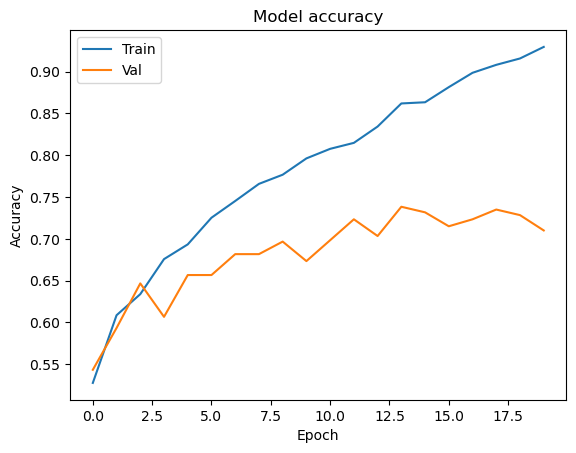

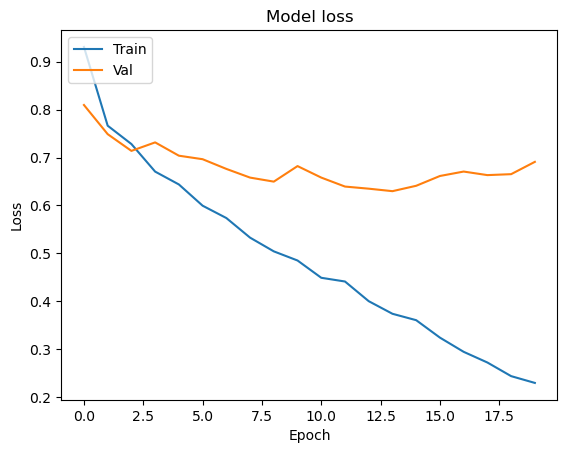

In [7]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=IMAGE_SHAPE), # Kernel size 3x3 e 16 filtros
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

plot_accuracy(history)
plot_loss(history)
